In [2]:
#필요한 모드 임포트
import os.path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from PIL import Image

from pathlib import Path
from tqdm import tqdm
from time import perf_counter

from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display

In [2]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 10178343068261943898
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6284115968
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1059919654526078912
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060 SUPER, pci bus id: 0000:01:00.0, compute capability: 7.5"
 xla_global_id: 416903419]

In [8]:
# #이미지 파일경로 저장 및 데이터 라벨링
# dir_ = Path('C:/Users/alstn/Desktop/153.반려동물 안구질환 데이터/01.데이터/1.Training/원천데이터/TS1/개/안구/일반/')

# import glob
# types = ('**/*.jpg', '**/*.png','**/*.jpeg') # the tuple of file types
# files_grabbed = []
# for files in types:
#     files_grabbed.extend(dir_.glob(files))
    
# print(len(files_grabbed))
# print(str(files_grabbed[61230]))
# print(str(files_grabbed[6000]).split("\\")[-2])

176815
C:\Users\alstn\Desktop\153.반려동물 안구질환 데이터\01.데이터\1.Training\원천데이터\TS1\개\안구\일반\비궤양성각막질환\하\3405.jpg
유


In [3]:
#이미지 파일경로 저장 및 데이터 라벨링
dir_ = Path('C:/Users/alstn/Desktop/153.반려동물 안구질환 데이터/01.데이터/1.Training/원천데이터/TS1/개/안구/일반/')

import glob
types = ('**/*.jpg', '**/*.png','**/*.jpeg') # the tuple of file types
files_grabbed = []
for files in types:
    files_grabbed.extend(dir_.glob(files))

print(files_grabbed[1])
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """

    labels = []
    for i in range(len(filepath)):
        if(str(filepath[i]).split("\\")[-2] == '무'):
            labels.append(str(filepath[i]).split("\\")[-2])
        else:
            labels.append(str(filepath[i]).split("\\")[-3])

    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
             
    # 경로와 라벨 concatenate
    df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    df = df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return df

df = proc_img(files_grabbed)
df.head(5)

C:\Users\alstn\Desktop\153.반려동물 안구질환 데이터\01.데이터\1.Training\원천데이터\TS1\개\안구\일반\결막염\유\1.jpg


,Filepath,Label
0,C:\Users\alstn\Desktop\153.반려동물 안구질환 데이터\01.데이...,백내장
1,C:\Users\alstn\Desktop\153.반려동물 안구질환 데이터\01.데이...,백내장
2,C:\Users\alstn\Desktop\153.반려동물 안구질환 데이터\01.데이...,무
3,C:\Users\alstn\Desktop\153.반려동물 안구질환 데이터\01.데이...,결막염
4,C:\Users\alstn\Desktop\153.반려동물 안구질환 데이터\01.데이...,무


In [4]:
#Validation 데이터를 
#이미지 파일경로 저장 및 데이터 라벨링
dir_ = Path('C:/Users/alstn/Desktop/153.반려동물 안구질환 데이터/01.데이터/2.Validation/원천데이터/VS/개/안구/일반/')

import glob
types = ('**/*.jpg', '**/*.png','**/*.jpeg') # the tuple of file types
files_grabbed = []
for files in types:
    files_grabbed.extend(dir_.glob(files))

print(files_grabbed[1])
def proc_img(filepath):
    """
   		이미지데이터의 경로와 label데이터로 데이터프레임 만들기 
    """
    labels = []
    for i in range(len(filepath)):
        if(str(filepath[i]).split("\\")[-2] == '무'):
            labels.append(str(filepath[i]).split("\\")[-2])
        else:
            labels.append(str(filepath[i]).split("\\")[-3])
    
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
             
    # 경로와 라벨 concatenate
    vs_df = pd.concat([filepath, labels], axis=1)

    # index 재설정
    vs_df = vs_df.sample(frac=1,random_state=0).reset_index(drop = True)
    
    return vs_df

vs_df = proc_img(files_grabbed)
vs_df.head(5)

C:\Users\alstn\Desktop\153.반려동물 안구질환 데이터\01.데이터\2.Validation\원천데이터\VS\개\안구\일반\결막염\무\D0_2988b642-60a5-11ec-8402-0a7404972c70.jpg


,Filepath,Label
0,C:\Users\alstn\Desktop\153.반려동물 안구질환 데이터\01.데이...,비궤양성각막질환
1,C:\Users\alstn\Desktop\153.반려동물 안구질환 데이터\01.데이...,무
2,C:\Users\alstn\Desktop\153.반려동물 안구질환 데이터\01.데이...,궤양성각막질환
3,C:\Users\alstn\Desktop\153.반려동물 안구질환 데이터\01.데이...,백내장
4,C:\Users\alstn\Desktop\153.반려동물 안구질환 데이터\01.데이...,무


In [5]:
#데이터 라벨링된 결과
print(f'Number of pictures: {df.shape[0]}\n')
print(f'Number of different labels: {len(df.Label.unique())}\n')
print(f'Labels: {df.Label.unique()}')

Number of pictures: 176815

Number of different labels: 11

Labels: ['백내장' '무' '결막염' '궤양성각막질환' '안검내반증' '안검종양' '색소침착성각막염' '유루증' '안검염' '핵경화'
 '비궤양성각막질환']


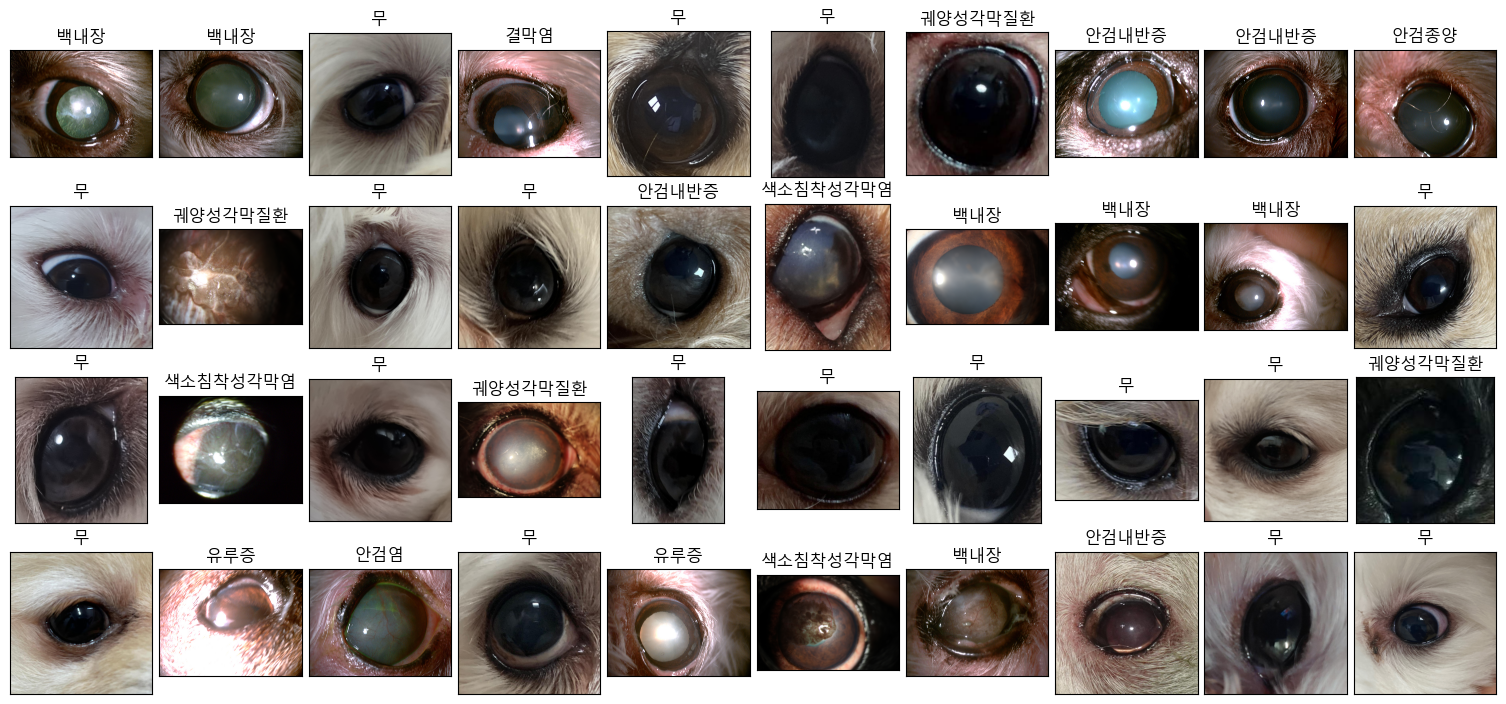

In [6]:
#사진들의 라벨링된 결과를 확인하기 위해 이미지 출력
plt.rc("font", family="Malgun Gothic")

fig, axes = plt.subplots(nrows=4, ncols=10, figsize=(15, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(Image.open(df.Filepath[i]))
    ax.set_title(df.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

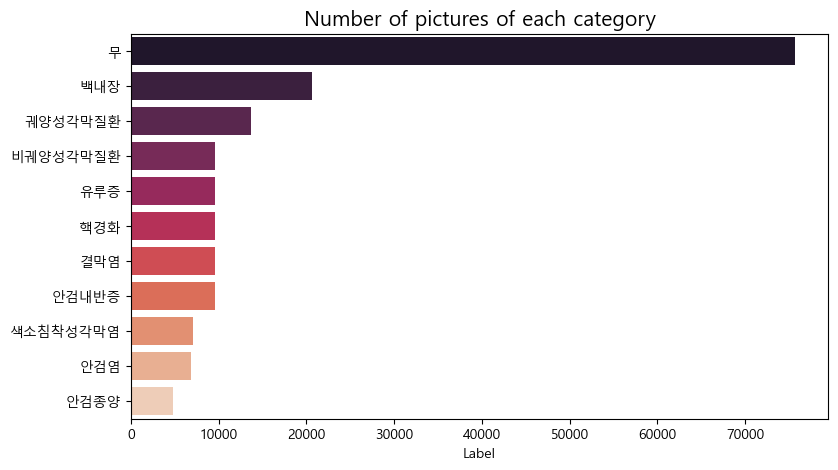

In [7]:
#다이어그램으로 확인
vc = df['Label'].value_counts()
plt.figure(figsize=(9,5))
sns.barplot(x = vc, y = vc.index, palette = "rocket",orient='h')
plt.title("Number of pictures of each category", fontsize = 15)
plt.show()

In [8]:
#테스트 셋 연습 셋 확인
train_df,test_df = train_test_split(df, test_size=0.2,random_state=0)
train_df.shape,test_df.shape

((141452, 2), (35363, 2))

In [9]:

# import numpy as np
# import tensorflow as tf


from keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale = 1./255)
# val_datagen = ImageDataGenerator(rescale = 1./255)

# train_gen = train_datagen.flow_from_directory('C:/Users/alstn/Desktop/153.반려동물 안구질환 데이터/01.데이터/1.Training/원천데이터/TS1/개/안구/일반/',
#                                                  target_size = (150, 150),
#                                                  batch_size = 32,
#                                                  class_mode = 'categorical')
# val_gen  = val_datagen.flow_from_directory('C:/Users/alstn/Desktop/153.반려동물 안구질환 데이터/01.데이터/2.Validation/원천데이터/VS/개/안구/일반/',
#                                                  target_size = (150, 150),
#                                                  batch_size = 32,
#                                                  class_mode = 'categorical')

In [8]:
def create_gen():
    # 생성기 및 데이터 증강으로 이미지 로드
    train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    )

    test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
    )

    train_images = train_generator.flow_from_dataframe(
        dataframe=train_df,
        x_col='Filepath', # 파일위치 열이름
        y_col='Label', # 클래스 열이름
        target_size=(224, 224), # 이미지 사이즈
        color_mode='rgb', # 이미지 채널수
        class_mode='categorical', # Y값(Label값)
        batch_size=32,
        shuffle=True, # 데이터를 섞을지 여부
        seed=0,
        #subset='training', # train 인지 val인지 설정
        rotation_range=30, # 회전제한 각도 30도
        zoom_range=0.15, # 확대 축소 15%
        width_shift_range=0.2, # 좌우이동 20%
        height_shift_range=0.2, # 상하이동 20%
        shear_range=0.15, # 반시계방햐의 각도
        horizontal_flip=True, # 좌우 반전 True
        fill_mode="nearest"
        # 이미지 변경시 보완 방법 (constant, nearest, reflect, wrap) 4개 존재
    )

    val_images = train_generator.flow_from_dataframe(
        dataframe=vs_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        #subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest"
    )

    test_images = test_generator.flow_from_dataframe(
        dataframe=test_df,
        x_col='Filepath',
        y_col='Label',
        target_size=(224, 224),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        shuffle=False
    )
    
    return train_generator,test_generator,train_images,val_images,test_images

In [11]:
models = {
    "DenseNet201": {"model":tf.keras.applications.DenseNet201, "perf":0},
    "DenseNet121": {"model":tf.keras.applications.DenseNet121, "perf":0},
    "MobileNetV2": {"model":tf.keras.applications.MobileNetV2, "perf":0},
    "EfficientNetB0": {"model":tf.keras.applications.EfficientNetB0, "perf":0},
    "EfficientNetB1": {"model":tf.keras.applications.EfficientNetB1, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "MobileNetV3Large": {"model":tf.keras.applications.MobileNetV3Large, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}
# Create the generators
train_generator,test_generator,train_images,val_images,test_images=create_gen()
print('\n')

def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(11, activation='softmax')(x)
    # 라벨 개수가 11개이기 때문에 Dencs도 11로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model
with tf.device('/GPU:0'):
    for name, model in models.items():
            # 전이 학습 모델 가져오기
            m = get_model(model['model'])
            models[name]['model'] = m
    
            start = perf_counter()
    
            # 모델 학습
            history = m.fit(train_images,validation_data=val_images,epochs=1,verbose=0)
    
            # 학습시간과 val_accuracy 저장
            duration = perf_counter() - start
            duration = round(duration,2)
            models[name]['perf'] = duration
            print(f"{name:20} trained in {duration} sec")
    
            val_acc = history.history['val_accuracy']
            models[name]['val_acc'] = [round(v,4) for v in val_acc]

Found 141452 validated image filenames belonging to 11 classes.
Found 22058 validated image filenames belonging to 11 classes.
Found 35363 validated image filenames belonging to 11 classes.


DenseNet201          trained in 3788.07 sec
DenseNet121          trained in 3788.56 sec
MobileNetV2          trained in 3806.57 sec
EfficientNetB0       trained in 3797.34 sec
27018416/27018416 [==============================] - 1s 0us/step
EfficientNetB1       trained in 3765.56 sec
87910968/87910968 [==============================] - 4s 0us/step
InceptionV3          trained in 3759.41 sec
MobileNetV3Large     trained in 3743.18 sec
234545216/234545216 [==============================] - 12s 0us/step
ResNet152V2          trained in 3778.85 sec
94765736/94765736 [==============================] - 5s 0us/step
ResNet50             trained in 3775.43 sec
ResNet50V2           trained in 3784.66 sec
80134624/80134624 [==============================] - 1s 0us/step
VGG19                trained in 3739.48 

In [12]:
# test데이터로 모델 성능 예측
for name, model in models.items():
    
    # Predict the label of the test_images
    pred = models[name]['model'].predict(test_images)
    pred = np.argmax(pred,axis=1)

    # Map the label
    labels = (train_images.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]

    y_test = list(test_df.Label)
    acc = accuracy_score(y_test,pred)
    models[name]['acc'] = round(acc,4)
    print(f'**{name} has a {acc * 100:.2f}% accuracy on the test set**')
   
# Create a DataFrame with the results
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][-1], 
                          models[name]['acc'],
                          models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','accuracy','Training time (sec)'])
df_results.sort_values(by='accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

1106/1106 [==============================] - 973s 878ms/step
**DenseNet201 has a 65.34% accuracy on the test set**
1106/1106 [==============================] - 860s 776ms/step
**DenseNet121 has a 65.15% accuracy on the test set**
1106/1106 [==============================] - 841s 760ms/step
**MobileNetV2 has a 64.83% accuracy on the test set**
1106/1106 [==============================] - 853s 771ms/step
**EfficientNetB0 has a 47.23% accuracy on the test set**
1106/1106 [==============================] - 836s 755ms/step
**EfficientNetB1 has a 47.46% accuracy on the test set**
1106/1106 [==============================] - 837s 756ms/step
**InceptionV3 has a 62.52% accuracy on the test set**
1106/1106 [==============================] - 839s 758ms/step
**MobileNetV3Large has a 55.58% accuracy on the test set**
1106/1106 [==============================] - 843s 761ms/step
**ResNet152V2 has a 64.62% accuracy on the test set**
1106/1106 [==============================] - 839s 758ms/step
**ResNet

,model,val_accuracy,accuracy,Training time (sec)
0,DenseNet201,0.6037,0.6534,3788.07
1,DenseNet121,0.6217,0.6515,3788.56
2,MobileNetV2,0.6122,0.6483,3806.57
3,ResNet50V2,0.6082,0.6471,3784.66
4,ResNet152V2,0.6199,0.6462,3778.85
5,Xception,0.6210,0.6330,3771.01
6,InceptionV3,0.6243,0.6252,3759.41
7,VGG16,0.6278,0.6223,3747.64
8,VGG19,0.5968,0.6122,3739.48
9,MobileNetV3Large,0.5705,0.5558,3743.18


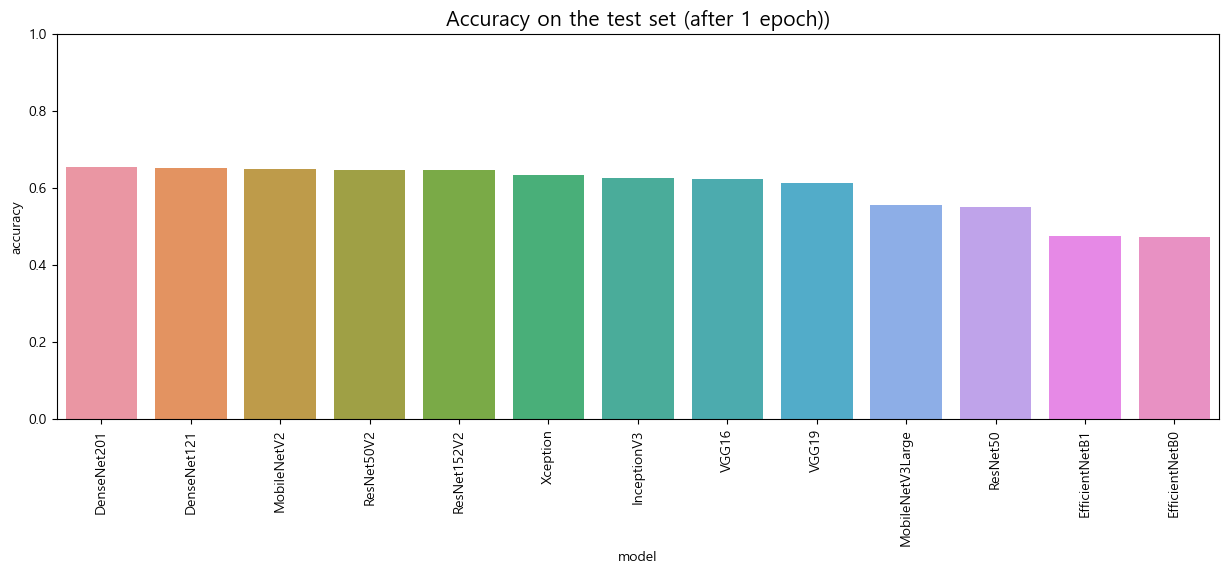

In [13]:
#모델별 정확도 차트로 확인
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'accuracy', data = df_results)
plt.title('Accuracy on the test set (after 1 epoch))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

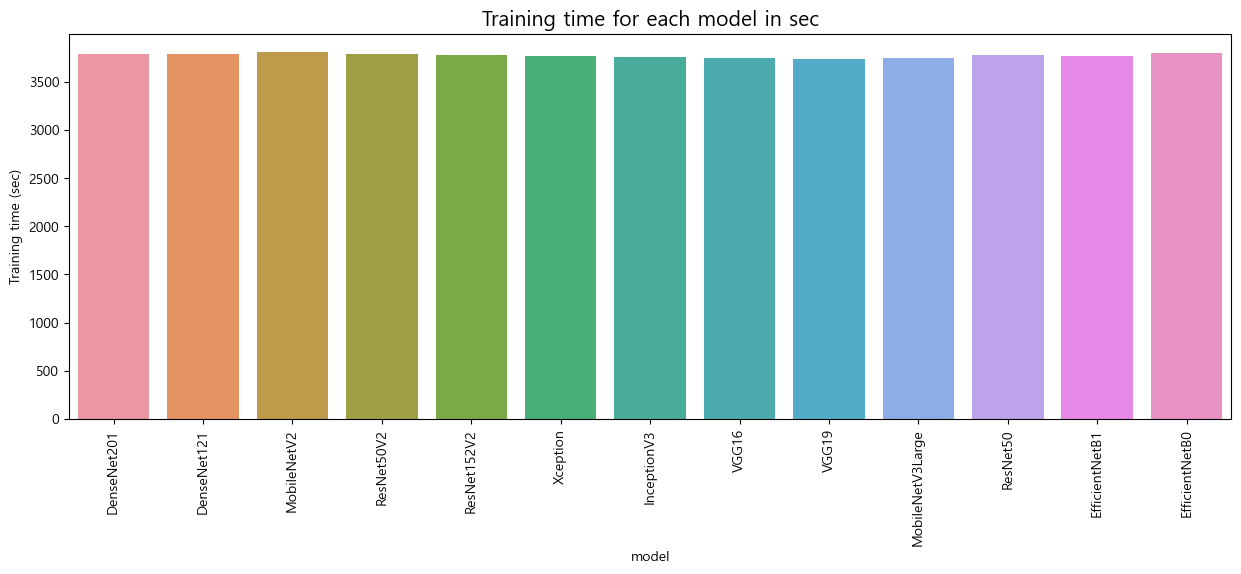

In [14]:
#모델별 트레이닝 시간 차트로 확인
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'Training time (sec)', data = df_results)
plt.title('Training time for each model in sec', fontsize = 15)
# plt.ylim(0,20)
plt.xticks(rotation=90)
plt.show()

In [12]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(224, 224, 3),
                'include_top':False,
                'weights':'imagenet',
                'pooling':'avg'}
    
    pretrained_model = model(**kwargs)
    pretrained_model.trainable = False # 레이어를 동결 시켜서 훈련중 손실을 최소화 한다.
    
    inputs = pretrained_model.input

    x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
    x = tf.keras.layers.Dense(128, activation='relu')(x)

    outputs = tf.keras.layers.Dense(11, activation='softmax')(x)
    # 라벨 개수가 11개이기 때문에 Dencs도 11로 설정
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [13]:
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5),
             keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

#데이터셋을 가지고 모델 전이 학습
train_df,test_df = train_test_split(df, test_size=0.2, random_state=0)
train_generator,test_generator,train_images,val_images,test_images=create_gen()

model = get_model(tf.keras.applications.DenseNet201) #위 결과에서 가장 좋은 성과를 낸 모델을 사용
history = model.fit(train_images,validation_data=val_images,epochs=10,callbacks=callbacks)

Found 141452 validated image filenames belonging to 11 classes.
Found 22058 validated image filenames belonging to 11 classes.
Found 35363 validated image filenames belonging to 11 classes.
Epoch 1/5
4421/4421 [==============================] - 3823s 860ms/step - loss: 0.9958 - accuracy: 0.6406 - val_loss: 1.0648 - val_accuracy: 0.6217
Epoch 2/5
4421/4421 [==============================] - 3817s 863ms/step - loss: 0.9035 - accuracy: 0.6673 - val_loss: 1.1560 - val_accuracy: 0.6093
Epoch 3/5
4421/4421 [==============================] - 3809s 862ms/step - loss: 0.8668 - accuracy: 0.6782 - val_loss: 1.1184 - val_accuracy: 0.6064
Epoch 4/5
4421/4421 [==============================] - 3735s 845ms/step - loss: 0.8420 - accuracy: 0.6858 - val_loss: 1.2729 - val_accuracy: 0.6228
Epoch 5/5
4421/4421 [==============================] - 3755s 849ms/step - loss: 0.8226 - accuracy: 0.6904 - val_loss: 1.1797 - val_accuracy: 0.6263


In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_2 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_2[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_2[0][0]']       
                                )                                                           

 conv2_block4_0_relu (Activatio  (None, 56, 56, 160)  0          ['conv2_block4_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block4_1_conv (Conv2D)   (None, 56, 56, 128)  20480       ['conv2_block4_0_relu[0][0]']    
                                                                                                  
 conv2_block4_1_bn (BatchNormal  (None, 56, 56, 128)  512        ['conv2_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block4_1_relu (Activatio  (None, 56, 56, 128)  0          ['conv2_block4_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv3_block2_0_relu (Activatio  (None, 28, 28, 160)  0          ['conv3_block2_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  20480       ['conv3_block2_0_relu[0][0]']    
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)       

 ization)                                                                                         
                                                                                                  
 conv3_block6_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block6_2_conv (Conv2D)   (None, 28, 28, 32)   36864       ['conv3_block6_1_relu[0][0]']    
                                                                                                  
 conv3_block6_concat (Concatena  (None, 28, 28, 320)  0          ['conv3_block5_concat[0][0]',    
 te)                                                              'conv3_block6_2_conv[0][0]']    
                                                                                                  
 conv3_blo

 conv3_block10_concat (Concaten  (None, 28, 28, 448)  0          ['conv3_block9_concat[0][0]',    
 ate)                                                             'conv3_block10_2_conv[0][0]']   
                                                                                                  
 conv3_block11_0_bn (BatchNorma  (None, 28, 28, 448)  1792       ['conv3_block10_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv3_block11_0_relu (Activati  (None, 28, 28, 448)  0          ['conv3_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv3_block11_1_conv (Conv2D)  (None, 28, 28, 128)  57344       ['conv3_block11_0_relu[0][0]']   
          

                                                                                                  
 conv4_block2_concat (Concatena  (None, 14, 14, 320)  0          ['conv4_block1_concat[0][0]',    
 te)                                                              'conv4_block2_2_conv[0][0]']    
                                                                                                  
 conv4_block3_0_bn (BatchNormal  (None, 14, 14, 320)  1280       ['conv4_block2_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_0_relu (Activatio  (None, 14, 14, 320)  0          ['conv4_block3_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_blo

 conv4_block7_0_relu (Activatio  (None, 14, 14, 448)  0          ['conv4_block7_0_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block7_1_conv (Conv2D)   (None, 14, 14, 128)  57344       ['conv4_block7_0_relu[0][0]']    
                                                                                                  
 conv4_block7_1_bn (BatchNormal  (None, 14, 14, 128)  512        ['conv4_block7_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block7_1_relu (Activatio  (None, 14, 14, 128)  0          ['conv4_block7_1_bn[0][0]']      
 n)                                                                                               
          

                                                                                                  
 conv4_block11_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block11_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block11_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block11_1_relu[0][0]']   
                                                                                                  
 conv4_block11_concat (Concaten  (None, 14, 14, 608)  0          ['conv4_block10_concat[0][0]',   
 ate)                                                             'conv4_block11_2_conv[0][0]']   
                                                                                                  
 conv4_block12_0_bn (BatchNorma  (None, 14, 14, 608)  2432       ['conv4_block11_concat[0][0]']   
 lization)

 ate)                                                             'conv4_block15_2_conv[0][0]']   
                                                                                                  
 conv4_block16_0_bn (BatchNorma  (None, 14, 14, 736)  2944       ['conv4_block15_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block16_0_relu (Activati  (None, 14, 14, 736)  0          ['conv4_block16_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block16_1_conv (Conv2D)  (None, 14, 14, 128)  94208       ['conv4_block16_0_relu[0][0]']   
                                                                                                  
 conv4_blo

                                                                                                  
 conv4_block20_1_conv (Conv2D)  (None, 14, 14, 128)  110592      ['conv4_block20_0_relu[0][0]']   
                                                                                                  
 conv4_block20_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block20_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block20_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block20_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block20_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block20_1_relu[0][0]']   
          

 on)                                                                                              
                                                                                                  
 conv4_block24_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block24_1_relu[0][0]']   
                                                                                                  
 conv4_block24_concat (Concaten  (None, 14, 14, 1024  0          ['conv4_block23_concat[0][0]',   
 ate)                           )                                 'conv4_block24_2_conv[0][0]']   
                                                                                                  
 conv4_block25_0_bn (BatchNorma  (None, 14, 14, 1024  4096       ['conv4_block24_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_blo

 conv4_block29_0_bn (BatchNorma  (None, 14, 14, 1152  4608       ['conv4_block28_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block29_0_relu (Activati  (None, 14, 14, 1152  0          ['conv4_block29_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block29_1_conv (Conv2D)  (None, 14, 14, 128)  147456      ['conv4_block29_0_relu[0][0]']   
                                                                                                  
 conv4_block29_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block29_1_conv[0][0]']   
 lization)                                                                                        
          

                                                                                                  
 conv4_block33_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block33_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block33_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block33_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block33_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block33_1_relu[0][0]']   
                                                                                                  
 conv4_block33_concat (Concaten  (None, 14, 14, 1312  0          ['conv4_block32_concat[0][0]',   
 ate)     

 conv4_block37_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block37_1_relu[0][0]']   
                                                                                                  
 conv4_block37_concat (Concaten  (None, 14, 14, 1440  0          ['conv4_block36_concat[0][0]',   
 ate)                           )                                 'conv4_block37_2_conv[0][0]']   
                                                                                                  
 conv4_block38_0_bn (BatchNorma  (None, 14, 14, 1440  5760       ['conv4_block37_concat[0][0]']   
 lization)                      )                                                                 
                                                                                                  
 conv4_block38_0_relu (Activati  (None, 14, 14, 1440  0          ['conv4_block38_0_bn[0][0]']     
 on)                            )                                                                 
          

                                                                                                  
 conv4_block42_0_relu (Activati  (None, 14, 14, 1568  0          ['conv4_block42_0_bn[0][0]']     
 on)                            )                                                                 
                                                                                                  
 conv4_block42_1_conv (Conv2D)  (None, 14, 14, 128)  200704      ['conv4_block42_0_relu[0][0]']   
                                                                                                  
 conv4_block42_1_bn (BatchNorma  (None, 14, 14, 128)  512        ['conv4_block42_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv4_block42_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block42_1_bn[0][0]']     
 on)      

 lization)                                                                                        
                                                                                                  
 conv4_block46_1_relu (Activati  (None, 14, 14, 128)  0          ['conv4_block46_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv4_block46_2_conv (Conv2D)  (None, 14, 14, 32)   36864       ['conv4_block46_1_relu[0][0]']   
                                                                                                  
 conv4_block46_concat (Concaten  (None, 14, 14, 1728  0          ['conv4_block45_concat[0][0]',   
 ate)                           )                                 'conv4_block46_2_conv[0][0]']   
                                                                                                  
 conv4_blo

 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 128)    118784      ['conv5_block2_0_relu[0][0]']    
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 128)   512         ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 128)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_blo

                                                                                                  
 conv5_block6_2_conv (Conv2D)   (None, 7, 7, 32)     36864       ['conv5_block6_1_relu[0][0]']    
                                                                                                  
 conv5_block6_concat (Concatena  (None, 7, 7, 1088)  0           ['conv5_block5_concat[0][0]',    
 te)                                                              'conv5_block6_2_conv[0][0]']    
                                                                                                  
 conv5_block7_0_bn (BatchNormal  (None, 7, 7, 1088)  4352        ['conv5_block6_concat[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block7_0_relu (Activatio  (None, 7, 7, 1088)  0           ['conv5_block7_0_bn[0][0]']      
 n)       

 lization)                                                                                        
                                                                                                  
 conv5_block11_0_relu (Activati  (None, 7, 7, 1216)  0           ['conv5_block11_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block11_1_conv (Conv2D)  (None, 7, 7, 128)    155648      ['conv5_block11_0_relu[0][0]']   
                                                                                                  
 conv5_block11_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block11_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_blo

 conv5_block15_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block15_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block15_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block15_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block15_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block15_1_relu[0][0]']   
                                                                                                  
 conv5_block15_concat (Concaten  (None, 7, 7, 1376)  0           ['conv5_block14_concat[0][0]',   
 ate)                                                             'conv5_block15_2_conv[0][0]']   
          

                                                                                                  
 conv5_block19_concat (Concaten  (None, 7, 7, 1504)  0           ['conv5_block18_concat[0][0]',   
 ate)                                                             'conv5_block19_2_conv[0][0]']   
                                                                                                  
 conv5_block20_0_bn (BatchNorma  (None, 7, 7, 1504)  6016        ['conv5_block19_concat[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block20_0_relu (Activati  (None, 7, 7, 1504)  0           ['conv5_block20_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_blo

 conv5_block24_0_relu (Activati  (None, 7, 7, 1632)  0           ['conv5_block24_0_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block24_1_conv (Conv2D)  (None, 7, 7, 128)    208896      ['conv5_block24_0_relu[0][0]']   
                                                                                                  
 conv5_block24_1_bn (BatchNorma  (None, 7, 7, 128)   512         ['conv5_block24_1_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 conv5_block24_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block24_1_bn[0][0]']     
 on)                                                                                              
          

                                                                                                  
 conv5_block28_1_relu (Activati  (None, 7, 7, 128)   0           ['conv5_block28_1_bn[0][0]']     
 on)                                                                                              
                                                                                                  
 conv5_block28_2_conv (Conv2D)  (None, 7, 7, 32)     36864       ['conv5_block28_1_relu[0][0]']   
                                                                                                  
 conv5_block28_concat (Concaten  (None, 7, 7, 1792)  0           ['conv5_block27_concat[0][0]',   
 ate)                                                             'conv5_block28_2_conv[0][0]']   
                                                                                                  
 conv5_block29_0_bn (BatchNorma  (None, 7, 7, 1792)  7168        ['conv5_block28_concat[0][0]']   
 lization)

 ate)                                                             'conv5_block32_2_conv[0][0]']   
                                                                                                  
 bn (BatchNormalization)        (None, 7, 7, 1920)   7680        ['conv5_block32_concat[0][0]']   
                                                                                                  
 relu (Activation)              (None, 7, 7, 1920)   0           ['bn[0][0]']                     
                                                                                                  
 avg_pool (GlobalAveragePooling  (None, 1920)        0           ['relu[0][0]']                   
 2D)                                                                                              
                                                                                                  
 dense_3 (Dense)                (None, 128)          245888      ['avg_pool[0][0]']               
          

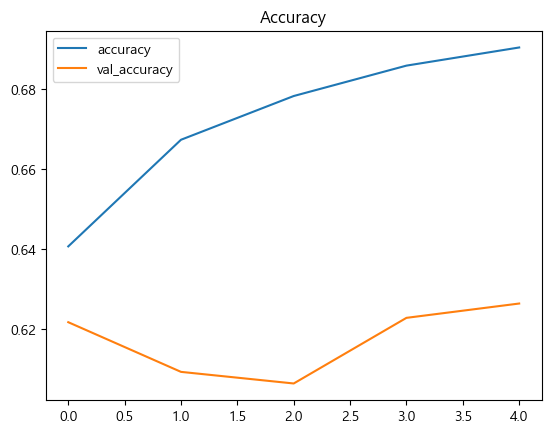

In [14]:
#정확도
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

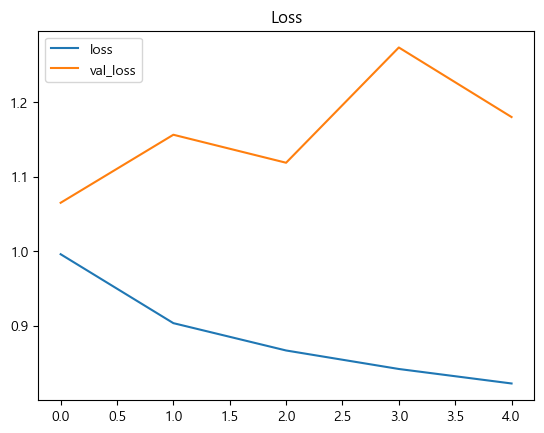

In [15]:
#손실도
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()